<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit5/Unit5NotesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

# Unit 5: Modeling with Lines (1 predictor)

Up until now, we've used data from something to predict itself; we've used Wembanyama's shooting free throws to predict him shooting free throws, soccer playes shooting goals to predict soccer plays shooting goals, amino acid chemcial shift vales to predict amino acid chemcial shift values.

In this unit, we will use data from one process to predict data from different process. The first example we'll see is using the temperature on a given day to predict how many bicycles are rented on that same day. We'll use that example to introduce:

- how to relate temperature and bike rentals with a straight line trend.
- how to improve our predictions by filtering our straight line through different likelihoods.

We'll then switch to predicting the length of babies using their age in months. This will present new challenges:

- how do we account for changing variation in baby length?
- do we always have to use straight lines for prediction, or can our lines be curvy?

I'll then return to the NBA context in order to show how to apply a hierarchical model structure in a linear model.

Finally, I'll do an example of how to use a linear model to classify things; in this case, flowers based on the lengths of their sepals (leaves).

Got all that? No? Well, no worries--we'll step through it all, one thing at a time.

## Straight Lines, Bikes, and Likelihoods

How does tempeture affect bike rentals in a city? I'm not sure, but I do have access to our textbooks data set that has the temperature and number of bikes rented for a give day. Let's check it out.

In [2]:
# Load the data into a pandas dataframe, and print it
url_bikes = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/bikes.csv'
# I could have put the url string directly into pd.read_csv()
bikes = pd.read_csv(url_bikes)

In [3]:
bikes

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0
...,...,...,...,...,...,...
343,90,9,4.22,0.48,0.3881,6
344,135,12,5.16,0.56,0.0896,1
345,13,15,4.22,0.87,0.3582,3
346,271,17,3.28,0.60,0.1343,5


Yes, there's more than just temperature and rented bike counts in there; we'll use the other variables in a later unit.

For now, let's graph the two variables we're interested in: temperature on the x axis, and rented count on the y axis.

<Axes: xlabel='temperature', ylabel='rented'>

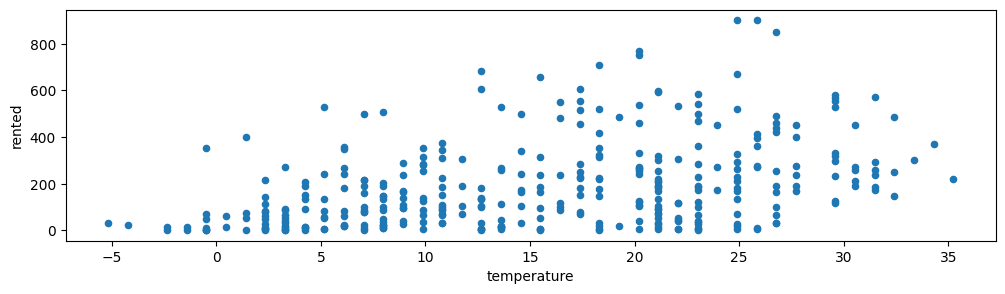

In [4]:
#scatter plot of temperature v. rented count of bikes
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")

Traditionally, we statisticians call x our predictor and y the predicted. I think its more useful to use temperature to predict the number of rented bikes, but the only reason we're not going the other direction is because I think that's silly in context--there's no math reason we're using temperature to predict number of bikes.

Anyway, before we get to our model, let's talk about what a line is, and why they're so darn useful.

For us, a line will be anything satifying this relationship: $y=mx + b$. Hopefully that's familiar from the algebra classes you've taken.
We're not actually gonna use those letters though; instead we'll write our lines as: $\hat{y}=α+βx$.

I'll call $\hat{y}$ y_hat, or y_pred. $α$ is known as a (y) intercept, and I'll refer to $β$ as a slope or a coefficient.

**Task1**:

What do the letters in $\hat{y}=α+βx$ tell me about my line?

> - $\alpha$ tells us where the line will intersect the y-axis – the number of bikes rented out at temperature 0
> - $\beta$ will tell us the rate of change of the line's points – the relationship between temperature and number of bikes
> - $\hat{y}$ is the number of bikes rented at a given temperature $x$

How is that helpful for using temperature to predict the number of rented bikes on a given day? Why use a line?

> It is helpful to use temperature because we assume that temperature and bike rentals are related. We can use a line to model a simple relationship between two variables.

Now that we know why lines are useful, and what assumptions we make when we use them--let's use them!

In [5]:
#lb stands for linear bike
with pm.Model() as model_lb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * bikes.temperature)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes.rented)

    #inference data object
    idata_lb = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


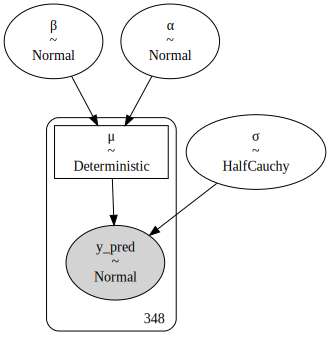

In [7]:
pm.model_to_graphviz(model_lb)

**Task 2**:

Compare and contrast this linear model structure from the models we've used in the past units. I recommend making a krusche diagram to help yourself out.

> We have priors and a likelihood in both models. However, now we're introducing a prior defined by a linear relationship between multiple priors.

Now that we've looked at how the model specification is new and different, let's see what line our model dreamed up.

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

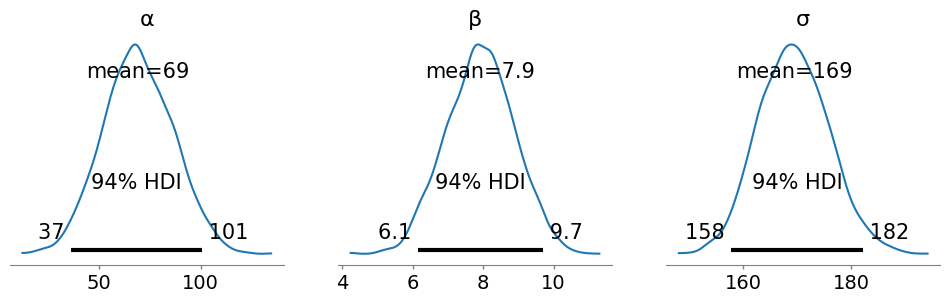

In [8]:
#plot of the posteriors for all the components of my line
#'~μ' means plot all variables except μ
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

Text(0, 0.5, 'rented bikes')

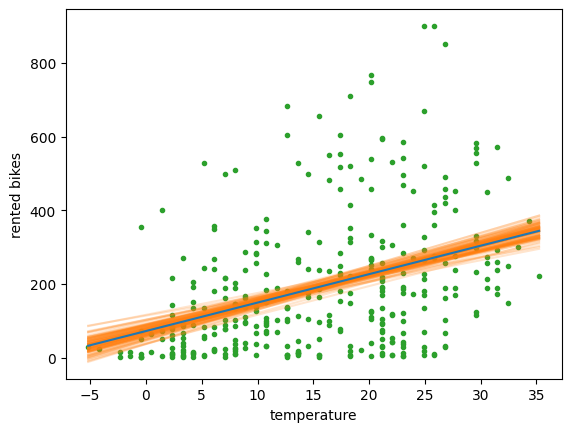

In [9]:
#grabs 100 posterior samples
posterior = az.extract(idata_lb, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")

**NOTE**:
The above lines, including the orange ones, only represent the mean of our posterior. These lines represeent what our model expects our data to look like, if it really is modeled well by a straight line.

**Task3**:

Using only the posterior visualizations above as a reference, does the linear model with normal likelihood do a good job explaining the relationship between temperature and number of rented bikes?

> It seems to capture the general trend of rentals going up as temperature increases. Although the data has a lot of variance, I notice that the area below the lines seems more dense, so that might be an issue.

Now that we've seen the mean, let's see the distribution of our models predictions.

Focus on the graph themselves for now. You can return to parse through the code that generates the graph later.

In [10]:
# posterior predictive check
pm.sample_posterior_predictive(idata_lb, model=model_lb,  extend_inferencedata=True)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'rented bikes')

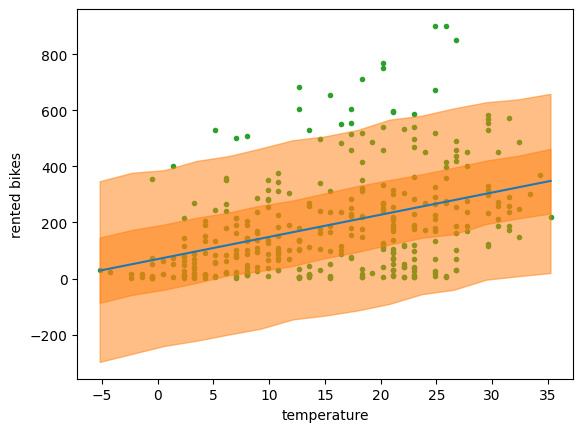

In [11]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")

Let's see how our model performs by assessing its predictions.

<Axes: xlabel='y_pred'>

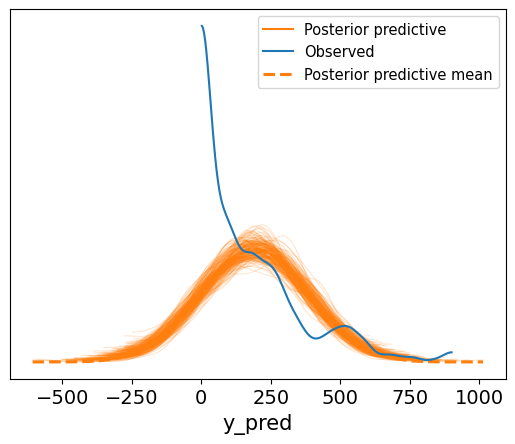

In [12]:
#posterior predictive check
az.plot_ppc(idata_lb, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Task4**:

How does the normal likelihood linear model's posterior predictive distribution perform?

> The top graph shows that it captures general trends, and around half the dataset is modeled by the overlapping line. It goes quite a bit into the negatives, though.
>
> By the bottom graph, I can tell that the posterior predictive is not exactly the best at capturing the trend of the dataset.

**Task5**:

Find a [likelihood](https://www.pymc.io/projects/docs/en/stable/api/distributions.html) that works better for the bikes data. Show that it works better by running the pymc model and doing a posterior predictive check.

*Hint*: Try plotting ```bikes.rented``` in order to see the shape of the raw data more clearly. Also: is the number of bikes discrete or continuous?

<Axes: ylabel='Density'>

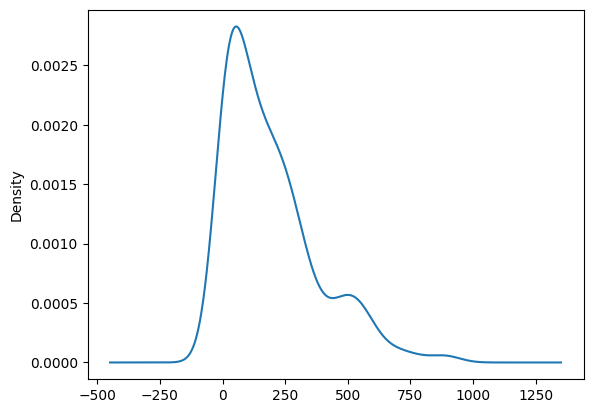

In [19]:
bikes.rented.plot.density()

In [24]:
#ANSWER5 cont.

#nbb stands for negative binomial bike model
with pm.Model() as model_nbb:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * bikes.temperature))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=bikes.rented)

    idata_nbb = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [25]:
#ANSWER5 cont.

#creates our posterior predictive distribution
pm.sample_posterior_predictive(idata_nbb, model = model_nbb, extend_inferencedata=True)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

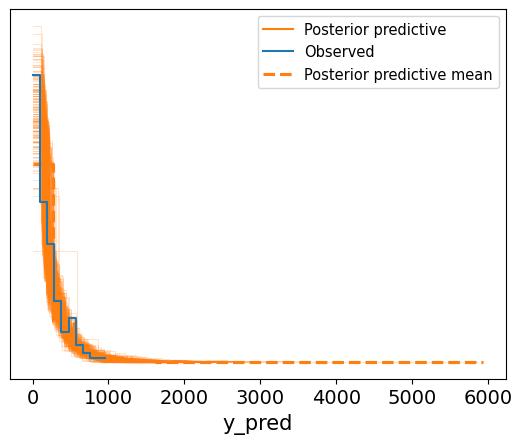

In [26]:
#ANSWER5 cont.

# posterior predictive check
az.plot_ppc(idata_nbb, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'rented bikes')

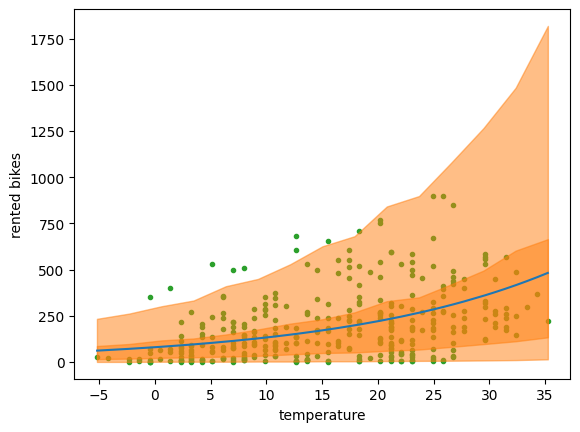

In [27]:
#ANSWER5 cont.

mean_line = idata_nbb.posterior["μ"].mean(("chain", "draw"))
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)
y_pred_q = idata_nbb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")

## Generalizing the Linear Model

That last model with the negative binomial likelihood is an example of a Generlized Linear Model (glm).

Linear models can have any likelihood, as long as the data is processed thorugh a linear function: $μ=α+βx$. We often denote the likelihood as $\phi(f(μ),θ)$, where $θ$ is all the priors we need, $μ$ is the linear function $α+βx$. In the normal model, $f(μ)=1̇⋅μ=μ$.

That changed when we used the negative binomial likelihood. A negative binomial's support is all positive; a common and quick way to transform a linear function into a function that's all positive is to apply it as an exponential power.

Like this: $e^{α+βx}$. That's what we did in the code
``` pm.math.exp(α + β * bikes.temperature) ``` .
Remember, temperature from the bikes data set is our predictor, x.


Anytime we shove $α+βx$ into a function before sliding it into our likelihood, we are generalizing our linear model. Usually we do this to make our chosen likelihood work better, as we did with the negative binomial example.

But we can generalize our line even with a normal likelihood. Let's see an example.


In [28]:
#load the data into a pandas dataframe, and print it
url_babies = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/babies.csv'
#I could have put the url string directly into pd.read_csv()
babies = pd.read_csv(url_babies)

<Axes: xlabel='month', ylabel='length'>

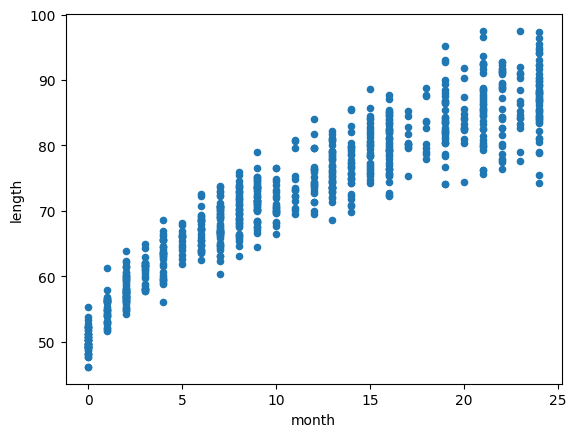

In [29]:
babies.plot.scatter('month','length')

The above is the lengths (heights) and ages of newborn/toddler baby girls, collected from the World Health Organization, and cleaned by the author of our textbook.

**Task6**:

Write a linear model with normal likelihood that uses a babies age in months to predict their length. Do not transform the linear part (yet).

Then use a posterior predictive check to assess how well our model fits our data, and comment on the fit.

In [52]:
with pm.Model() as model_baby1:
    alpha = pm.Normal("α", mu=40, sigma=5)
    beta = pm.Normal("β", mu=2, sigma=10)
    mu = pm.Deterministic("μ", alpha + beta * babies.month)

    sigma = pm.HalfNormal("σ", 20)
    
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=babies.length)
    
    idata_baby1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [53]:
pm.sample_posterior_predictive(idata_baby1, model=model_baby1, extend_inferencedata=True)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

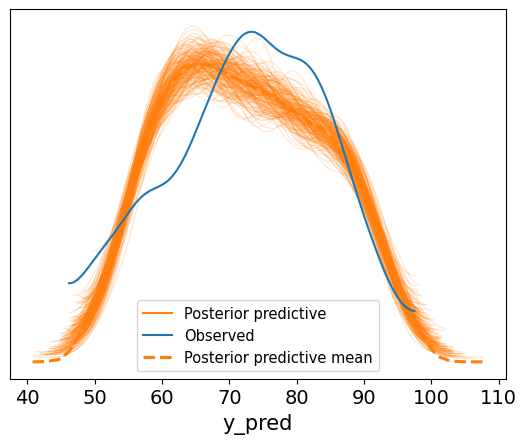

In [54]:
az.plot_ppc(idata_baby1, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'length')

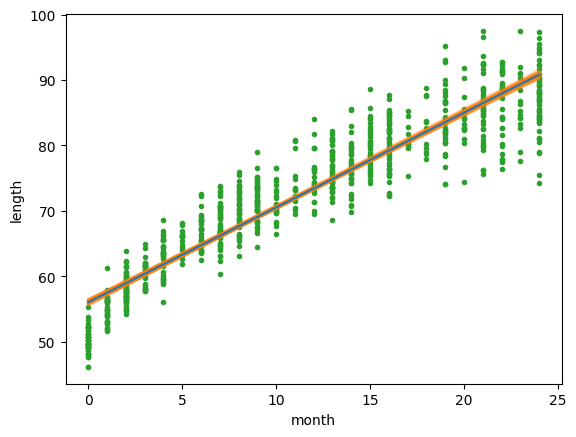

In [55]:
#grabs 100 posterior samples
posterior = az.extract(idata_baby1, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(babies.month.min(), babies.month.max(), 50),
    dims="plot_id"
)

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(babies.month, babies.length, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("month")
ax.set_ylabel("length")

The linear model seems to fit the dataset, but the PPC reveals a poor, but not terrible fit.

**Task7**:

Write a linear model with normal likelihood that uses a babies age in months to predict their length--but transfrom the linear part of our model to better fit the data. Make sure to use a function within the [PyMC math library](https://www.pymc.io/projects/docs/en/stable/api/math.html)

Then, use a posterior predictive check to assess how good our model fit is.

In [71]:
with pm.Model() as model_baby2:
    alpha = pm.Normal("α", mu=40, sigma=5)
    beta = pm.Normal("β", mu=2, sigma=10)
    mu = pm.Deterministic("μ", alpha + beta * pm.math.sin(babies.month))

    sigma = pm.HalfNormal("σ", 20)
    
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=babies.length)
    
    idata_baby2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [72]:
pm.sample_posterior_predictive(idata_baby2, model=model_baby1, extend_inferencedata=True)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

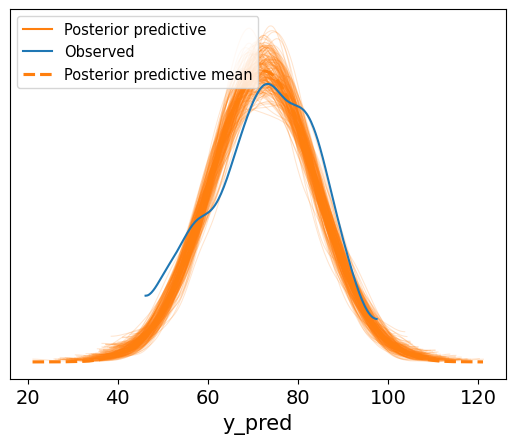

In [73]:
az.plot_ppc(idata_baby2, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'length')

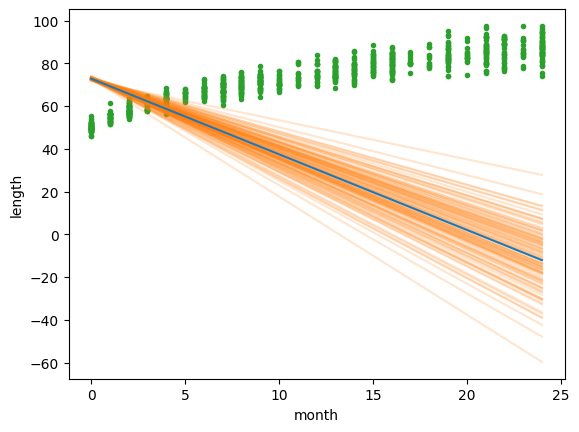

In [74]:
#grabs 100 posterior samples
posterior = az.extract(idata_baby2, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(babies.month.min(), babies.month.max(), 50),
    dims="plot_id"
)

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(babies.month, babies.length, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("month")
ax.set_ylabel("length")

Here's how to alter our model to account for the apparent trend that baby lengths get more variable as babies age.

In [ ]:
#vvba for variable variance babies
with pm.Model() as model_vvba:

    #priors for line for our mean
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #priors for the line for our standard deviation
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * pm.math.sqrt(babies.month))

    #standard deviation line; this allows our variance to vary over th x values
    σ = pm.Deterministic("σ", γ + δ * babies.month)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=babies.length)

    idata_vvba = pm.sample()

In [ ]:
#plots the posterior

_, ax = plt.subplots()

ax.plot(babies.month, babies.length, "C0.", alpha=0.1)

posterior_vvba = az.extract(idata_vvba)

μ_m = posterior_vvba["μ"].mean("sample").values
σ_m = posterior_vvba["σ"].mean("sample").values

ax.plot(babies.month, μ_m, c="k")
ax.fill_between(babies.month, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(babies.month, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("months")
ax.set_ylabel("length")

In [ ]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_vvba, model = model_vvba, extend_inferencedata=True
    )

In [ ]:
# posterior predictive check
az.plot_ppc(idata_vvba, num_pp_samples=200, colors=["C1", "C0", "C1"])

This is the best estimate of the mode thus far. Its still got some funky behavior on the left tail--the next step would be to try a T distribution as a likelihood.

### Comments on Priors in Linear Models

I've neglected any commentary on prior selection until now, in order to focus on the structure and ramifications of the linear model. But now I'll comment on lightly informative priors, which I will continue to use this entire unit, and which are a good default.

Lightly informative priors tell our model where a parameter IS NOT as opposed to strongly informative priors, which tell a model where a parameter IS. For example, all priors thus far have had a mean of 0, despite none of our actual slopes or y-ints  estimates ended being all that close to 0. We do this so that our model doesn't have to jump around to outrageously large numbers to check our parameter. What's an outragouesly large number? We let our model know based on the standard deviation of the prior.

The point: our priors don't have to be right, they just have to give our model a general idea of there to look, and where not to look.

That said, if you do have information about where to expect the y-intercept or slope in a linear model, then use that information to select a prior. Again, that's called an informative prior, and it would likely have the same nice properties of the lightly/weakly informative priors I've used thus far.

## Hierarchical Linear Models (1 predictor)

Now that I've talked about priors and linear models, let's investigate a context where it might make sense to use hyper priors and hierarchies.

That context is the individual NBA player statistics from the 2023/2024 season. I show the whole dataset in the next few code blocks, but we'll only concern ourselves with 3 things: FT%, FG%, and Pos (player position).


Some context on FT%, FG%, and Pos:

FT% is the same as in the Wembanyama example. We'll use it as the predictor, since free throws are nominally unaffected by any other aspects of a game, or even a season.

With that reasoning FT% could be a way to predict FG%, which is the accuracy of a players shooting during game play. FG% is basically how likely a player is to score points when they try to score points--and since scoring points is the method of winning, it's a statistic of great interest to teams and players. FG% is affected by all aspects of a game, so having something less variable to predict it, like FT%, would be nice.

The final wrinkle is Pos, or player position. As we saw in the soccer example, players with different roles on a team have different relationships to scoring.

In [ ]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

[Click here for more info on query](https://stackoverflow.com/questions/67341369/pandas-why-query-instead-of-bracket-operator).

In [ ]:
#only look at players who played more than 400 minutes
basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
basketball = basketball.query('`FT%` != 1.0')

In [ ]:
basketball

In [ ]:
#make scatter plot of FT% and FG% for NBA players form the 23/24 season
plt.scatter(basketball['FT%'] , basketball['FG%'],)

#label axes
plt.xlabel("FT%")
plt.ylabel("FG%")

**Task8**:

Look at the scatter plot above. Describe any patterns you see.

**Annser8**:

[*write your answer here*]

In [ ]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = basketball.Pos.cat.codes.values

#an array of the strings that represent position
pos_codes = basketball.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bb_coords = {"pos": pos_codes}

In [ ]:
#set up the 12 plots
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

**Task9**:

Describe the relationship between FT% (on the x axis), and FG% (y axis) for each of the positions.

Focus your effects on the 5 pure positions, C (center), PF (power forward), SF (small forward), SG (shooting guard), and PG (point guard).

Also: why am I less concerned with you describing the remaining combo postions?

**Answer9**:

[*write your answer here*]

Now that we've seen the raw data nd visualized it, let's formalize our guesses by building a model.

First, I'll run seperate linear regressions on each of the positions.

I let all the priors and likelihoods be normal. Again, a normality assumption is often a great place to start when building a model.

Additionally, I used a straight line function $α + βx$, as there doesn't appear to be a curve trend to my eye in any of the raw scatter plots.

In [ ]:
#nh for non hierarchical
with pm.Model(coords=bb_coords) as nh_model:
    #priors
    α = pm.Normal("α", mu=0, sigma=3, dims="pos")
    β = pm.Normal("β", mu=0, sigma=10, dims="pos")
    σ = pm.HalfNormal("σ", 1)

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[pos_idx] + β[pos_idx] * basketball['FT%'],
                  sigma=σ,
                  observed=basketball['FG%'])
    idata_nh_b = pm.sample()

In [ ]:
#plots the y-int and slope for each position
az.plot_forest(idata_nh_b, var_names=["α", "β"], combined=True, figsize=(10, 9))

Above are the slopes and y-intercepts our model came out with, for each of the positions.

Below is code to plot those lines (a y-int and a slope is a line) against the raw data. For now, foucs on the output,the graphs; you can return to parse the code later.

In [ ]:
#set out our 12 plots
_, ax = plt.subplots(2, 6, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)

#set up x values. Used to graph line of best fit
x_range = np.linspace(basketball['FT%'].min(), basketball['FT%'].max(), 10)

#grab posterior info
posterior = az.extract(idata_nh_b)

#for each position
for i, p in enumerate(pos_codes):
    #plot the raw data
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y = basketball.query('Pos == @p')['FG%'],
        marker=".")

    #gives our graphs titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("FT%")
    ax[i].set_ylabel("FG%", labelpad=10, rotation=0)

    #grab the slope and y-int
    alphas = posterior["α"].sel(pos=p)
    betas = posterior["β"].sel(pos=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    #plot the mean line, or line of best fit
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    #plot a 94% HDI of the line of best fit.
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    #set the limits of our graphs' window
    plt.xlim(basketball['FT%'].min() - 0.01, basketball['FT%'].max() + 0.01)
    plt.ylim(basketball['FG%'].min() - 0.01, basketball['FG%'].max() + 0.01)

**Task10**:

Describe the posteriors for each of the graphs above, and interpret them in context.

As a reminder, the context is: is FT% helpful in predicting FG%, within a given basketball position?

**Answer10**:

[*write your answer here*]



Even with priors, our estimates for the combo groups are widely uncertain.

Our solution to that problem is to use even more priors! specifically, we'll use hyper priors in a heirarchical model framework.

Look below to see what that looks like in the linear regression context.

In [ ]:
#h for hierarchical
with pm.Model(coords=bb_coords) as h_model:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=basketball['FG%'].mean(), sigma=3)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=3)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="pos")
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="pos")
    σ = pm.HalfNormal("σ", 5)

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[pos_idx] + β[pos_idx] * basketball['FT%'],
                  sigma=σ,
                  observed=basketball['FG%'])

    idata_h_b = pm.sample(target_accept=0.99)

**Task11**:

Describe similarities and differences between the code for h_model and the code for nh_model.

**Answer11**:

[*write your answer here*]

I'm not going to make any graphs for h_model, because

- this model has a tendency to generate divergneces in the its markov chains, even with increasing the target acceptance rate.
- we have a solution

h_model frames our guess as for the slope of one position as informed by knowledge of the other positions' slopes

hoff_model (hierarchical offest) frames our guess as a deflection from the overall mean.

Those two definitions are mathematicall equivalent. So why use one over the other?

The offest model is easier for our markov chains to munch on. For example, the model below tends to produce less divergences than the previous one.

In [ ]:
#hoff for hierarchical offset
with pm.Model(coords=bb_coords) as hoff_model:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=basketball['FG%'].mean(), sigma=3)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=3)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="pos")
    σ = pm.HalfNormal("σ", 5)

    #prior of beta is different; now, we predict how far our guess is from the
    #overall average
    β_offset = pm.Normal("β_offset", mu=0, sigma=3, dims="pos")
    β = pm.Deterministic("β", β_μ + β_offset * β_σ, dims="pos")

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[pos_idx] + β[pos_idx] * basketball['FT%'],
                  sigma=σ,
                  observed=basketball['FG%'])

    idata_hoff_b = pm.sample(target_accept = 0.99)

In [ ]:
#displays the y-ints and slopes of the offset hierachical model
az.plot_forest(idata_hoff_b, var_names=["α", "β"], combined=True, figsize=(10, 9))

In [ ]:
#set up plots
_, ax = plt.subplots(2, 6, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)
#x values for putting through our linear equation, in order to graph the line
x_range = np.linspace(basketball['FT%'].min(), basketball['FT%'].max(), 10)
#grab the posterior
posterior = az.extract(idata_hoff_b)

#plot all 12 lines against the data
for i, p in enumerate(pos_codes):
    #plot raw data
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y = basketball.query('Pos == @p')['FG%'],
        marker=".")
    #titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("FT%")
    ax[i].set_ylabel("FG%", labelpad=10, rotation=0)
    #grab posterior info
    alphas = posterior["α"].sel(pos=p)
    betas = posterior["β"].sel(pos=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    #plot the posterior
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    #set window size
    plt.xlim(basketball['FT%'].min() - 0.01, basketball['FT%'].max() + 0.01)
    plt.ylim(basketball['FG%'].min() - 0.01, basketball['FG%'].max() + 0.01)

**Task12**:

How does the hoff_model posterior differ from the nh_model posterior?

**Answer12**:

[*write your answer here*]

**Task13**:

Which model is better: nh_model, or hoff_model? Why?

Be sure to reference the graphs in your justification.

**Answer13**:

[*write your answer here*]

## Classification with Logistic Regression

Regression--what we've been doing this whole unit--predicts a continuous value based on input variable(s).

Classification assigns an exact label to a given data point. A common way to create a classification algorithm is to take a regression model, and apply a decision boudary to it. That decision boundary then lets us assign a label.

Example time:

In [ ]:
#load the data into a pandas dataframe, and print it
url_iris = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/iris.csv'
#I could have put the url string directly into pd.read_csv()
iris = pd.read_csv(url_iris,dtype={'species':'category'})

In [ ]:
iris

Above is the classic iris data set, which has info about three species of iris flowers. We'll try to predict whether a flower is setosa or versicolor using only sepal_length.

In [ ]:
#removes virginica
iris_sv = iris.query("species == ('setosa', 'versicolor')")

#numpy array of the two species, but
#but with 0 for each setosa and 1 for each veriscolor
species_codes = pd.Categorical(iris_sv["species"]).codes

#makes a numpy array of the sepal length values
sepal_len = iris_sv.sepal_length.values

#here I normalize the sepal length values.
#This makes it easier for pymc to process
sepal_len_c = sepal_len - sepal_len.mean()

In [ ]:
#plots setosa in blue and versicolor in orange.
#Darker dots means more points are there
plt.scatter(sepal_len_c, species_codes, marker=".", color=[f"C{x}" for x in species_codes], alpha = 0.2)

Note that 0 on the graph above represents the average sepal length of setosa and veriscolor iris flowers in the data set.

**Task14**:

Pick a sepal length from graph above as your boundary or decision value for when an iris is setosa or versicolor.

Bascially, eyeball a solution to our problem.

**Anwser14**:

[*write your answer here*]

Now that we've looked at the raw data and thought about the problem, let's cook up a model to make our decisions for us.

New things to look for:
- we transform our linear equation using something called a sigmoid (AKA logistic) curve. You'll see what it looks like soon.
- we add in a boundary decision value, $\frac{-α}{β}$. This tells our model that 50% probability of being one species or the other is our cut off.
- we use a bernoulli likelihood, since a flower from our spliced data set is either setosa (0) or versicolor (1).

In [ ]:
#li stands for logistic iris
with pm.Model() as model_li:

    #priors
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=5)

    #linear part of the model
    μ = α + sepal_len_c * β

    #the linear part, mu, is transformed via a sigmoid curve
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ))

    #this lets our model find a boudary value
    #which allows us to do classificiation
    #It is not neccesary for the model to run
    bd = pm.Deterministic("bd", -α / β)

    #likelihood
    y = pm.Bernoulli("y", p=θ, observed=species_codes)

    idata_li = pm.sample()

In [ ]:
#grab the posterior
posterior = idata_li.posterior
theta = posterior["θ"].mean(("chain", "draw"))

#this will help us tanslate from the standardized data back to the raw data
idx = np.argsort(sepal_len_c)

#set up the plot
_, ax = plt.subplots(figsize=(12, 6))

#plot the posterior
ax.plot(sepal_len_c[idx], theta[idx], color="C0", lw=2)
ax.vlines(posterior["bd"].mean(("chain", "draw")), 0, 1, color="C2", zorder=0)

#bd for boundary
#these two lines plot our boundary or decision line, which is what we could use
#to predict the sepcies of a flower using sepal length
bd_hdi = az.hdi(posterior["bd"])
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color="C2", alpha=0.6, lw=0)

#scatter plot of raw data
ax.scatter(sepal_len_c, species_codes, marker=".", color=[f"C{x}" for x in species_codes], alpha = 0.2)

#plots the sigmoid regression
az.plot_hdi(sepal_len_c, posterior["θ"], color="C0", ax=ax, fill_kwargs={"lw": 0})

#labels
ax.set_xlabel('sepal length')
ax.set_ylabel("θ", rotation=0)

# # use original scale for xticks
locs, _ = plt.xticks()
ax.set_xticks(locs, np.round(locs + sepal_len_c.mean(), 1))

**Task15**:

Describe the above graph, and how it answers our question:

What value of sepal length should we use to decide if an iris is a setosa or a versicolor?

**Answer15**:

[*write your answer here*]

## Summary

We did a lot this unit. We:

- learned what a linear model is, and how to make one
- played with different likelihood and priors for various linear models
- generalized the linear part of our model to most curves, like square root, and a new one, the sigmoid.
- learned how to model variable variance (AKA heteroskedasticity) with babies
- walked through an example of a linear hierarchical model with NBA data, and discussed why we would and would not want to use one.
- learned a way to turn a regression model into a classification, flower identifying machine

Mainly, we learned ways to use some source of data (how hot it is outside) to predict a different source of data (how many people are riding bikes). That task, predicting something given something else, fits such a broad range of problems that the rest of this course is adding complexity to what you've seen in this unit.

For example: next unit, we'll try to predict how many people are renting bikes using not only the temperature, but *gasp* the humidity and time of day.

